In [1]:
import os
from keras.models import Sequential
from keras.layers.core import  Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.utils.vis_utils import plot_model
from shutil import copy
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [2]:
Indicator_list=["RSI","Stoch","MFI","UO","WPR"]

TRAIN_CONFIG=0

indicator=Indicator_list[TRAIN_CONFIG]

In [3]:
df_original=pd.read_csv(f"C:\\Users\\ffleader1\\AppData\\Roaming\\MetaQuotes\\Tester\\1640F6577B1C4EC659BF41EA9F6C38ED\\Agent-127.0.0.1-3000\\MQL5\\Files\\{indicator}_data.csv", header=None)
df_original.drop_duplicates(keep=False,inplace=True)
df_original.to_csv('trimmed_duplicated_data.csv', index=False,header=None,float_format='%.8f')

In [4]:
def oversampling(dataframe):
    new_df=dataframe.copy()
    new_df.reset_index(drop=True, inplace=True)
    class_data=dataframe.iloc[:,len(dataframe.columns)-1]
    print(class_data.value_counts())
    unq=np.unique(class_data)
    series_val=[]
    arr=[]
    dis=[]
    sr=class_data.value_counts()

    for v in unq:
        series_val.append(v)
        diff=sr.max()-sr[v]
        if diff==0:
            ratio=0
        else:
            ratio=np.power(1/sr[v],sr[v]/(sr.sum()))
        arr.append(ratio)
    inv_sum=1/np.sum(arr)
    for v in arr:
        dis.append(inv_sum*v)
    new_df_count=sr.max()*len(sr)-len(dataframe)
    rand_res=np.random.choice(series_val,new_df_count,p=dis)
    seed=0
    print("before", type(new_df))
    for v in rand_res:
        tdf=dataframe.loc[dataframe[dataframe.columns[len(dataframe.columns)-1]] == v]
        tdf.sample(frac=1,random_state=seed)
        #pd.concat(new_df,tdf.iloc[0])
        new_df=new_df.append(tdf.iloc[0])
        new_df.reset_index(drop=True, inplace=True)
        seed+=1
    print("after", type(new_df))
    new_class_data=new_df.iloc[:,len(new_df.columns)-1]
    print(new_class_data)
    return new_df


df= oversampling(df_original)
print(df.iloc[:,len(df.columns)-1].value_counts())

2    998
1    156
0    125
Name: 8, dtype: int64
before <class 'pandas.core.frame.DataFrame'>
after <class 'pandas.core.frame.DataFrame'>
0       2.0
1       2.0
2       2.0
3       2.0
4       0.0
       ... 
2989    1.0
2990    0.0
2991    1.0
2992    0.0
2993    1.0
Name: 8, Length: 2994, dtype: float64
0.0    1018
2.0     998
1.0     978
Name: 8, dtype: int64


In [5]:
train_val_data=df.sample(frac=0.8,random_state=200) #random state is a seed value
test_data=df.drop(train_val_data.index)
train_data=train_val_data.sample(frac=0.8,random_state=200)
val_data=train_val_data.drop(train_data.index)
train_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)


In [6]:
attribute_train_data=train_data.iloc[:,0:len(train_data.columns)-1]
class_train_data=train_data.iloc[:,len(train_data.columns)-1]
attribute_val_data=val_data.iloc[:,0:len(train_data.columns)-1]
class_val_data=val_data.iloc[:,len(train_data.columns)-1]
attribute_test_data=test_data.iloc[:,0:len(test_data.columns)-1]
class_test_data=test_data.iloc[:,len(test_data.columns)-1]

In [7]:
print(class_train_data.value_counts())


0.0    655
1.0    634
2.0    627
Name: 8, dtype: int64


In [8]:
attribute_train_norm =attribute_train_data
attribute_val_norm =attribute_val_data
attribute_test_norm =attribute_test_data

In [9]:
# attribute_train_norm = pd.DataFrame(MinMaxScaler().fit_transform(attribute_train_data), columns=attribute_train_data.columns)
# attribute_val_norm = pd.DataFrame(MinMaxScaler().fit_transform(attribute_val_data), columns=attribute_val_data.columns)
# attribute_test_norm = pd.DataFrame(MinMaxScaler().fit_transform(attribute_test_data), columns=attribute_test_data.columns)

In [10]:
class_train_cat = to_categorical(class_train_data, len(np.unique(class_train_data)))
class_val_cat = to_categorical(class_val_data, len(np.unique(class_val_data)))
class_test_cat = to_categorical(class_test_data, len(np.unique(class_test_data)))

In [11]:
print(class_train_data)
print(class_train_cat)

0       0.0
1       0.0
2       0.0
3       1.0
4       0.0
       ... 
1911    0.0
1912    1.0
1913    0.0
1914    2.0
1915    2.0
Name: 8, Length: 1916, dtype: float64
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [12]:
#print(attribute_train_norm)
#print(class_train_cat )

In [13]:
input_dim=len(attribute_test_norm.columns)
output_dim=len(np.unique(class_train_data))
EPOCHS = 50
INIT_LR = 1e-4

In [14]:
activation_func=["sigmoid", "softmax", "relu", "softsign", "tanh", "selu", "elu"]
activation1=activation_func[3]
activation2=activation_func[1]

In [15]:
ckpt_cb = [EarlyStopping(monitor='val_accuracy', patience=10)]

In [16]:
model = Sequential()

model.add(Dense(30, input_dim=input_dim, activation=activation1))
model.add(Dense(50, activation=activation1))
model.add(Dense(50, activation=activation1))
model.add(Dense(30, activation=activation1))
#model.add(Dense(30, activation=activation1))
model.add(Dense(output_dim, activation=activation2))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                270       
_________________________________________________________________
dense_2 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_4 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 93        
Total params: 5,993
Trainable params: 5,993
Non-trainable params: 0
_________________________________________________________________


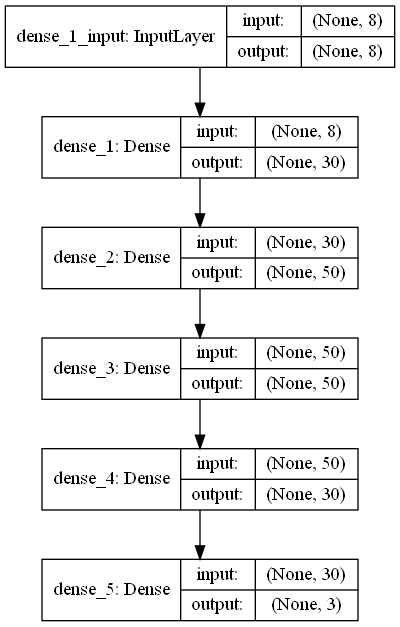

In [17]:
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [18]:
opt = Adam(lr=INIT_LR, decay=INIT_LR/EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])



In [19]:
print("[INFO] Training Network")
history = model.fit(attribute_train_norm,class_train_cat,validation_data=(attribute_val_norm,class_val_cat),epochs=EPOCHS,callbacks=ckpt_cb)


[INFO] Training Network

Train on 1916 samples, validate on 479 samples
Epoch 1/50
1916/1916 [==============================] - 1s 327us/step - loss: 1.0784 - accuracy: 0.4676 - val_loss: 0.9897 - val_accuracy: 0.6430
Epoch 2/50
1916/1916 [==============================] - 0s 216us/step - loss: 0.9251 - accuracy: 0.6414 - val_loss: 0.8536 - val_accuracy: 0.6785

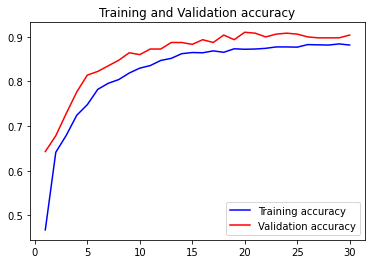

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(acc) + 1)
plt.plot(epochs,acc, 'b', label='Training accuracy')
plt.plot(epochs,val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.show()

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [21]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(attribute_test_norm,class_test_cat)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
599/599 [==============================] - 0s 65us/step
Test Accuracy: 89.14858102798462


In [22]:
#print(attribute_train_norm )
#print(class_train_data)

In [23]:
model.save(f"{indicator}.hdf5")

In [24]:
save_file=f"{indicator}_model.txt"
try:
    with open(save_file, 'w') as wt:
        for layer in model.layers:
            weights_bias = layer.get_weights()
            weights_bias_flatten=[]
            for w in weights_bias[0]:
                weights = w.flatten()
                weights_bias_flatten.append(w)
            biases = weights_bias[1].flatten()
            weights_bias_flatten.append(biases)
            wb_len=len(weights_bias_flatten)
            for i in range(len(biases)):
                neuron=[]
                for j in range(len(weights_bias_flatten)):
                    neuron.append(weights_bias_flatten[j][i])
                wt.write("["+','.join(map(str,neuron))+"]\n")
            act_func=str(layer.activation).split(" ")[1]
            print("act_func: ", act_func)
            wt.write("###"+act_func+"\n")
    copy(save_file,os.path.join(r"C:\Users\ffleader1\AppData\Roaming\MetaQuotes\Terminal\Common\Files",save_file))
except IOError as e:
    print(e)

act_func:  softsign
act_func:  softsign
act_func:  softsign
act_func:  softsign
act_func:  softmax


In [25]:
Xnew = np.asarray([[21, 4, 19, 96, 9, 11, 19, 99]])

ynew = model.predict(Xnew)
print(ynew)
print(np.sum(ynew))

[[0.07393688 0.23932509 0.686738  ]]
1.0


In [29]:
rand_matrix=np.random.rand(1000,8)
rand_matrix=rand_matrix*100
print(rand_matrix)
y_pred_rand = model.predict(rand_matrix)
buy=0
sell=0
nothing=0
for a in y_pred_rand:
    #print(a)
    idx=np.argmax(a)
    if idx==0 :
        sell+=1
    elif idx==1 :
        buy+=1
    else:
        nothing+=1
print("Buy: ",(buy/len(y_pred_rand)))
print("Sell: ",(sell/len(y_pred_rand)))
print("Nothing: ",(nothing/len(y_pred_rand)))

[[71.90334431 74.52448679 75.2233969  ... 80.28149462 38.57801132
  93.17797955]
 [15.39181145 49.00365528 59.3065136  ... 98.90540654 36.4672601
  84.9949945 ]
 [69.51594613 41.60269731 56.48231565 ... 17.58321011 10.83570909
  36.7116301 ]
 ...
 [73.0423016  55.20440681 82.33568458 ... 69.65526072  5.8520085
  19.86029213]
 [ 0.15271153 68.5914258  12.1311156  ... 48.36201873 50.31964166
  78.52980093]
 [ 2.59402945 80.65317631 28.11621587 ... 80.37725409 24.8775113
  77.78845211]]
Buy:  0.155
Sell:  0.176
Nothing:  0.669


In [27]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(attribute_test_norm)
#print(class_test_cat)
#print("------------")
#print( y_pred)

# y_pred = model.predict(attribute_test_norm)
#
# m=0
# n=0
# for a, b in y_pred:
#     if a>b:
#         m+=1
#     else:
#         n+=1
#
# print("val: ",(m/len(y_pred)))
# print("val: ",(n/len(y_pred)))
# print(np.sum([m,n]))
buy=0
sell=0
nothing=0
for a in y_pred:
    #print(a)
    idx=np.argmax(a)
    if idx==0 :
        sell+=1
    elif idx==1 :
        buy+=1
    else:
        nothing+=1
print("buy: ",(buy/len(y_pred)))
print("sell: ",(sell/len(y_pred)))
print("nothing: ",(nothing/len(y_pred)))



# y_pred = model.predict(attribute_test_norm)
# m=0
# n=0
# p=0
# q=0
# for a, b, c, d in y_pred:
#     if a>b and a>c and a >d:
#         m+=1
#     if b>c and b >d and b>a:
#         n+=1
#     if c > d and c>a and c>b:
#         p+=1
#     if d > a and d>b and d>c:
#         q+=1
# print("val: ",(m/len(y_pred)))
# print("val: ",(n/len(y_pred)))
# print("val: ",(p/len(y_pred)))
# print("val: ",(q/len(y_pred)))
# print(np.sum([m,n,p,q]))

buy:  0.3038397328881469
sell:  0.32387312186978295
nothing:  0.3722871452420701


In [28]:
try:
    df_debug_data=pd.read_csv(f"C:\\Users\\ffleader1\\AppData\\Roaming\\MetaQuotes\\Tester\\1640F6577B1C4EC659BF41EA9F6C38ED\\Agent-127.0.0.1-3000\\MQL5\\Files\\debug.csv", header=None)
    df_debug_data.reset_index(drop=True, inplace=True)
    df_debug=df_debug_data.iloc[:,0:len(train_data.columns)-1]
    condition_debug=np.asarray(df_debug_data.iloc[:,len(train_data.columns)-1])
    y_debug = model.predict(df_debug)
    buy =0
    sell=0
    same=0
    inverse=0
    nothing=0
    for idx, val in enumerate(y_debug):
    #print(a)
        max_val=np.argmax(val)
        if max_val==0 :
            inverse+=1
            if condition_debug[idx]==0:
                buy+=1
            elif condition_debug[idx]==1:
                sell+=1
        elif max_val==1:
            same+=1
            if condition_debug[idx]==0:
                sell+=1
            elif condition_debug[idx]==1:
                buy+=1
        else:
            nothing+=1
    print("buy: ",(buy/len(y_debug)))
    print("sell: ",(sell/len(y_debug)))
    print("same: ",(same/len(y_debug)))
    print("inverse: ",(inverse/len(y_debug)))
    print("nothing: ",(nothing/len(y_debug)))
except Exception as e:
    print(e)

[Errno 2] No such file or directory: 'C:\\Users\\ffleader1\\AppData\\Roaming\\MetaQuotes\\Tester\\1640F6577B1C4EC659BF41EA9F6C38ED\\Agent-127.0.0.1-3000\\MQL5\\Files\\debug.csv'
